### Task VII: Equivariant quantum neural networks

In this task you are supposed to get started with equivariant quantum neural networks by implementing a Z_2 × Z_2 equivariant quantum neural network. Z_2 is a symmetry group an as an example we will generate a simple classical dataset which is respects the Z_2 x Z_2 symmetry.

This example is explained in the paper https://arxiv.org/abs/2205.06217 and additional background can be found in https://arxiv.org/abs/2210.08566. 

- Generate a classification dataset with two classes and two features x_1 and x_2 which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x). An example can be found in the first reference paper.
- Train a QNN to solve the classification problem
- Train an Z_2 x Z_2 equivariant QNN to solve the classification problem and compare the results.



The study referenced [1] has presented a comprehensive solution to this task, complete with thorough benchmarks. The associated GitHub repository (https://github.com/ZhongtianD/EQNN) contains implementations of the introduced quantum circuit in Pennylane interfacing to Autograd. 

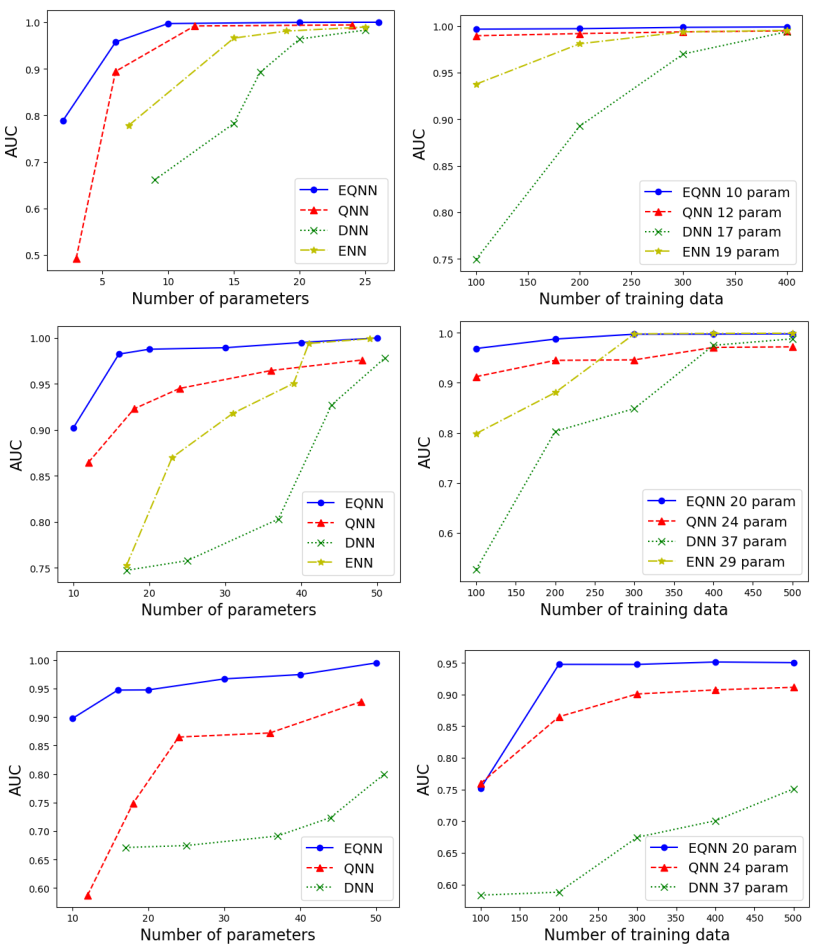

In this notebook, we aim to explore a different QNN architecture from one mentioned in the reference. We'll also reinterpret some of the mathematical expressions to align with our understanding and adapt the program to utilize PennyLane's PyTorch interface.

In [53]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

#### I. Generate Data with $Z_2$ x $Z_2$ Symmetry

As explained in [2], we will generate the dataset with the following property: 

$$y(x_1, x_2) = y(x_2, x_1) = y(-x_1, -x_2) $$

which means invariance under exchange and sign inversion of inputs.

Specifically, function $y(x_1, x_2)$ is expressed as: 

$$
y: \left(\sqrt{(x_1 + 1)^2 + (x_2 - 1)^2} < r\right) \lor \left(\sqrt{(x_1 - 1)^2 + (x_2 + 1)^2} < r\right)
$$


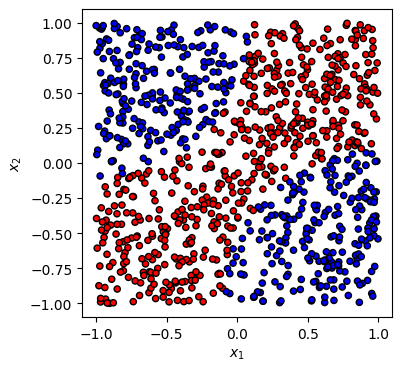

In [54]:
def generate_data(samples, center=[[-1.0, 1.0],[1.0, -1.0]], radius=1.1):
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1 # 2D: -1 to 1
        y = np.linalg.norm(x - center[0]) < radius or np.linalg.norm(x - center[1]) < radius
        
        Xvals.append(x)
        yvals.append(float(y))
    return np.array(Xvals), np.array(yvals)

def plot_data(X, y, fig=None, ax=None):
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X[:, 0], X[:, 1],  c=y, cmap=matplotlib.colors.ListedColormap(['red','blue']), s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
               
X_, y_ = generate_data(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X_, y_, fig=fig, ax=ax)
plt.show()



Before defining the models, we will first create some util functions, including the BCE Loss and Fidelity Loss also used in [1]. 

In [55]:

def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

def density_matrix(state):
    # return torch.mm(state, torch.conj(state).t())
    return torch.matmul(state, torch.conj(state).t())

def bce_loss(params, X, y, state_labels, q_circuit):
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]

    for i in range(X.size(0)):  # Assuming x is a PyTorch tensor with shape [batch_size, features]
        y_pred = q_circuit(params, X[i], dm_labels[0])
        loss += - y[i] * torch.log(y_pred) - (1 - y[i]) * torch.log(1 - y_pred)

    return loss / X.size(0)

# https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier/
def fidel_loss(params, X, y, state_labels, q_circuit):
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    
    for i in range(X.size(0)):
        fidelity = q_circuit(params, X[i], dm_labels[int(y[i])])
        loss += (1 - fidelity) ** 2
        
    return loss / X.size(0)

def test_bce(params, x, state_labels, q_circuit):
    fidelity_values = []
    predicted = []

    dm_labels = [density_matrix(s) for s in state_labels]
    
    for i in range(x.size(0)): 
        fidelities = q_circuit(params, x[i], dm_labels[0])
        predicted.append(torch.round(fidelities))
        fidelity_values.append(fidelities)

    return torch.tensor(predicted), torch.tensor(fidelity_values)

def test_fidel(params, x, state_labels, q_circuit):
    fidelity_values = []
    predicted = []

    dm_labels = [density_matrix(s) for s in state_labels]
    
    for i in range(x.size(0)): 
        fidelities = torch.tensor([q_circuit(params, x[i], dm) for dm in dm_labels])
        best_fidel = torch.argmax(fidelities)
        predicted.append(best_fidel)
        fidelity_values.append(fidelities[0])

    return torch.tensor(predicted), torch.tensor(fidelity_values)

def accuracy_score(y_true, y_pred):
    correct = torch.sum(y_true == y_pred).item()
    return correct / y_true.size(0)

#### II. Quantum Neural Network

In [56]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface='torch')
def q_circuit(params, x, y):
    # Data encoding
    for i, feature in enumerate(x):
        qml.RY(feature, wires=i)
    # Variational layers
    for p in params:
        qml.RX(p[0], wires=0)
        qml.RY(p[1], wires=0)
        qml.RZ(p[2], wires=0)
        qml.RY(p[3], wires=1)
        qml.CNOT(wires=[0, 1])
    
    # Measurement: expectation of Pauli-Z on 1st qubit
    return qml.expval(qml.Hermitian(y, wires=[0]))


Prameters Before:
Layer 0: tensor([0.9393, 0.5185, 0.6238, 0.8056], grad_fn=<UnbindBackward0>)
Layer 1: tensor([0.2666, 0.5485, 0.1931, 0.9386], grad_fn=<UnbindBackward0>)
Layer 2: tensor([0.4858, 0.0794, 0.0354, 0.2973], grad_fn=<UnbindBackward0>)


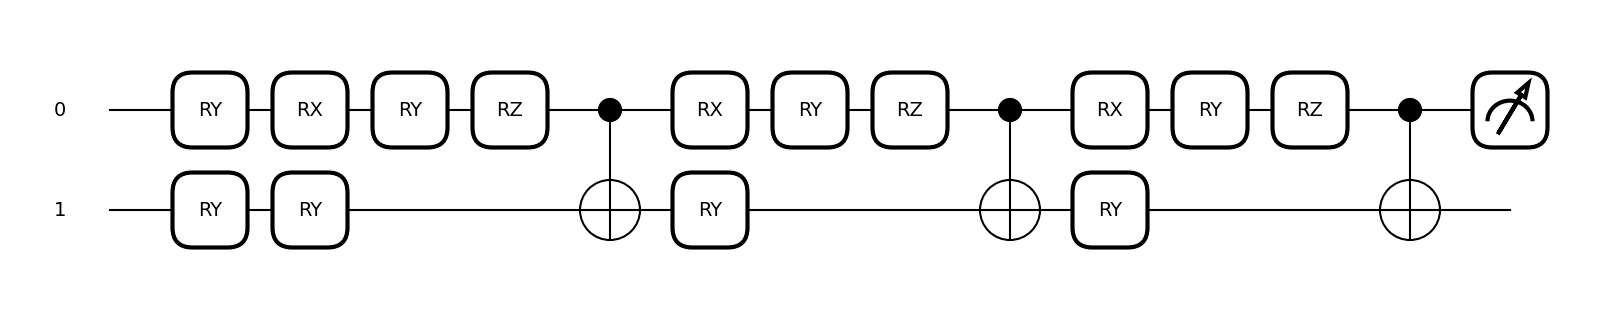

Epoch: 0 | Loss: 0.2662084400653839 | Test Accuracy: 0.4188  
Epoch: 1 | Loss: 0.25984498858451843 | Test Accuracy: 0.3812  
Epoch: 2 | Loss: 0.25468719005584717 | Test Accuracy: 0.4078  
Epoch: 3 | Loss: 0.2503114640712738 | Test Accuracy: 0.4609  
Epoch: 4 | Loss: 0.2467319518327713 | Test Accuracy: 0.5031  
Epoch: 5 | Loss: 0.2437678724527359 | Test Accuracy: 0.4984  
Epoch: 6 | Loss: 0.24093522131443024 | Test Accuracy: 0.5156  
Epoch: 7 | Loss: 0.23780830204486847 | Test Accuracy: 0.5422  
Epoch: 8 | Loss: 0.2342030256986618 | Test Accuracy: 0.5656  
Epoch: 9 | Loss: 0.23010054230690002 | Test Accuracy: 0.5938  
Epoch: 10 | Loss: 0.2255609780550003 | Test Accuracy: 0.6156  
Epoch: 11 | Loss: 0.22069981694221497 | Test Accuracy: 0.6547  
Epoch: 12 | Loss: 0.2156711369752884 | Test Accuracy: 0.6734  
Epoch: 13 | Loss: 0.21063227951526642 | Test Accuracy: 0.6937  
Epoch: 14 | Loss: 0.2057136595249176 | Test Accuracy: 0.7125  
Prameters After:
Layer 0: tensor([0.7833, 0.6052, 1.1259, 

In [57]:
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = torch.tensor([label_0, label_1], requires_grad=False)

num_training = 160
num_test = 640

X_train, y_train = generate_data(num_training)
X_test, y_test = generate_data(num_test)

num_layers = 3
learning_rate = 0.01
epochs = 20
batch_size = 32

beta1 = 0.9
beta2 = 0.999

params = torch.rand(num_layers, 4, requires_grad=True, dtype=torch.float32)
optimizer = torch.optim.Adam([params], lr=learning_rate, betas=(beta1, beta2))

print("Prameters Before:")
for i, p in enumerate(params):
    print("Layer {}: {}".format(i, p))

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# fig, ax = plt.subplot()
fig, ax = qml.draw_mpl(q_circuit)(params, X_train[0], density_matrix(state_labels[0]))
plt.show()

y_pred_initial, _ = test_fidel(params, X_test, state_labels, q_circuit)

for epoch in range(epochs):
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
    
        optimizer.zero_grad()
        loss = fidel_loss(params, X_batch, y_batch, state_labels, q_circuit)
        loss.backward()
        optimizer.step()
    
    y_pred, _ = test_fidel(params, X_test, state_labels, q_circuit)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Epoch: {epoch} | Loss: {loss.item()} | Test Accuracy: {test_accuracy:.4f}  ")

print("Prameters After:")
for i, p in enumerate(params):
    print("Layer {}: {}".format(i, p))

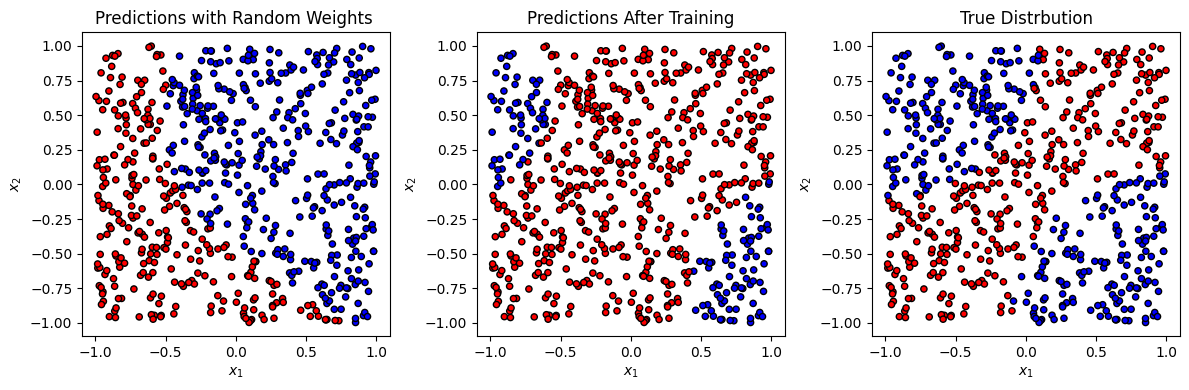

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_data(X_test, y_pred_initial, fig, axes[0])
plot_data(X_test, y_pred, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title(f"Predictions with Random Weights ")
axes[1].set_title(f"Predictions After Training")
axes[2].set_title("True Distrbution")
plt.tight_layout()
plt.show()

#### III. $Z_2$ x $Z_2$ Equivariant QNN

In [59]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface='torch')
def equi_circuit(params, x, y):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    for p in params:
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)
        
        qml.RX(p[0], wires=0)
        qml.RX(p[0], wires=1)
        
        qml.CNOT(wires=[0,1])
        qml.RZ(p[1], wires=1)
        qml.CNOT(wires=[0,1])
        
    return qml.expval(qml.Hermitian(y, wires=[0,1]))


Prameters Before:
Layer 0: tensor([0.3976, 0.4166], grad_fn=<UnbindBackward0>)
Layer 1: tensor([0.1230, 0.2626], grad_fn=<UnbindBackward0>)
Layer 2: tensor([0.2080, 0.6164], grad_fn=<UnbindBackward0>)
Layer 3: tensor([0.0393, 0.9066], grad_fn=<UnbindBackward0>)
Layer 4: tensor([0.5251, 0.2154], grad_fn=<UnbindBackward0>)


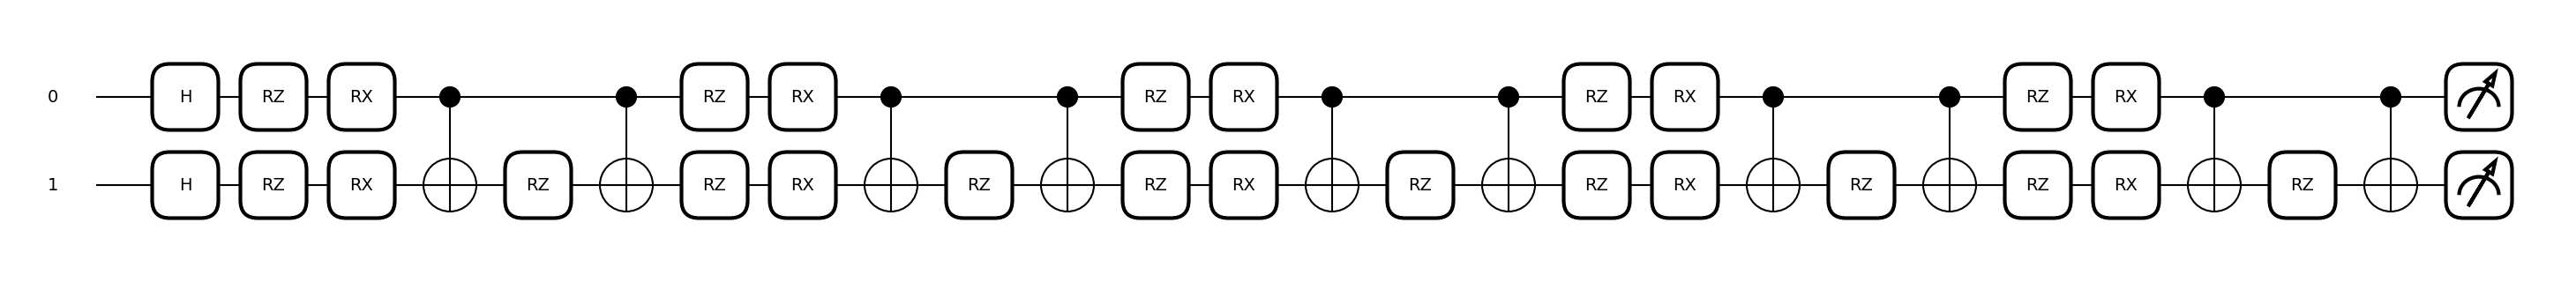

Epoch: 0 | Loss: 0.8976640105247498 | Test Accuracy: 0.5484  
Epoch: 1 | Loss: 0.8833252191543579 | Test Accuracy: 0.5500  
Epoch: 2 | Loss: 0.8738465309143066 | Test Accuracy: 0.5516  
Epoch: 3 | Loss: 0.8604304194450378 | Test Accuracy: 0.5547  
Epoch: 4 | Loss: 0.8412608504295349 | Test Accuracy: 0.5594  
Epoch: 5 | Loss: 0.8124275803565979 | Test Accuracy: 0.5797  
Epoch: 6 | Loss: 0.7725463509559631 | Test Accuracy: 0.5938  
Epoch: 7 | Loss: 0.7241702675819397 | Test Accuracy: 0.6234  
Epoch: 8 | Loss: 0.672816812992096 | Test Accuracy: 0.6438  
Epoch: 9 | Loss: 0.6252576112747192 | Test Accuracy: 0.6562  
Epoch: 10 | Loss: 0.5857207775115967 | Test Accuracy: 0.6813  
Epoch: 11 | Loss: 0.5547077059745789 | Test Accuracy: 0.7281  
Epoch: 12 | Loss: 0.5305711627006531 | Test Accuracy: 0.7609  
Epoch: 13 | Loss: 0.5113435983657837 | Test Accuracy: 0.7844  
Epoch: 14 | Loss: 0.49552908539772034 | Test Accuracy: 0.8125  
Prameters After:
Layer 0: tensor([1.1779, 0.3244], grad_fn=<Unbin

In [60]:
label_0 = [[1], [1],[1], [1]]
label_1 = [[1], [-1],[-1], [1]]
state_labels = torch.tensor([label_0, label_1], requires_grad=False)/2

num_training = 160
num_test = 640

X_train, y_train = generate_data(num_training)
X_test, y_test = generate_data(num_test)

num_layers = 5
learning_rate = 0.01
epochs = 20
batch_size = 32

beta1 = 0.9
beta2 = 0.999

params = torch.rand(num_layers, 2, requires_grad=True, dtype=torch.float32)
optimizer = torch.optim.Adam([params], lr=learning_rate, betas=(beta1, beta2))

print("Prameters Before:")
for i, p in enumerate(params):
    print("Layer {}: {}".format(i, p))

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# fig, ax = plt.subplot()
fig, ax = qml.draw_mpl(equi_circuit)(params, X_train[0], density_matrix(state_labels[0]))
plt.show()

y_pred_initial, _ = test_bce(params, X_test, state_labels, equi_circuit)

for epoch in range(epochs):
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
    
        optimizer.zero_grad()
        loss = bce_loss(params, X_batch, y_batch, state_labels, equi_circuit)
        loss.backward()
        optimizer.step()
    
    y_pred, _ = test_bce(params, X_test, state_labels, equi_circuit)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Epoch: {epoch} | Loss: {loss.item()} | Test Accuracy: {test_accuracy:.4f}  ")

print("Prameters After:")
for i, p in enumerate(params):
    print("Layer {}: {}".format(i, p))

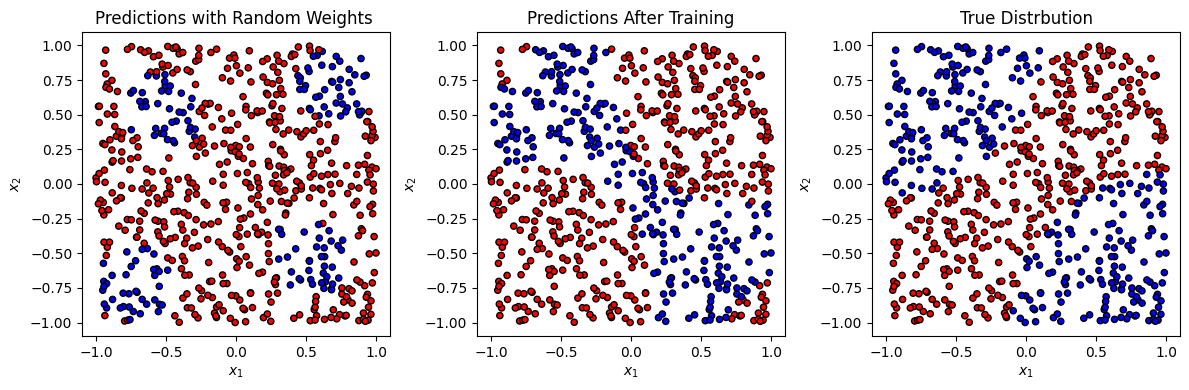

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_data(X_test, y_pred_initial, fig, axes[0])
plot_data(X_test, y_pred, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title(f"Predictions with Random Weights ")
axes[1].set_title(f"Predictions After Training")
axes[2].set_title("True Distrbution")
plt.tight_layout()
plt.show()

* [1] Z. Dong et al., “$\mathbb{Z}_2\times \mathbb{Z}_2$ Equivariant Quantum Neural Networks: Benchmarking against Classical Neural Networks,” Axioms, vol. 13, no. 3, p. 188, Mar. 2024, doi: 10.3390/axioms13030188.
* [2] J. J. Meyer et al., “Exploiting symmetry in variational quantum machine learning,” PRX Quantum, vol. 4, no. 1, p. 010328, Mar. 2023, doi: 10.1103/PRXQuantum.4.010328.
* [3] Q. T. Nguyen et al., “Theory for Equivariant Quantum Neural Networks.” arXiv, Oct. 16, 2022. doi: 10.48550/arXiv.2210.08566.
